<a href="https://colab.research.google.com/github/ajagota7/Reward-Shaping/blob/main/gridworld_ope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Environment

In [85]:
class GridWorld:
    def __init__(self, height, width, start, end, bad_regions, good_regions):
        self.height = height
        self.width = width
        self.start = start
        self.end = end
        self.bad_regions = bad_regions
        self.good_regions = good_regions

    def reset(self):
        self.agent_position = self.start

    def step(self, action):
        x, y = self.agent_position

        if action == "up" and y < self.height - 1:
            y += 1
        elif action == "down" and y > 0:
            y -= 1
        elif action == "left" and x > 0:
            x -= 1
        elif action == "right" and x < self.width - 1:
            x += 1

        self.agent_position = (x, y)

        if self.agent_position == self.end:
            reward = 3
            done = True
        elif self.agent_position in self.bad_regions:
            reward = -1
            done = False
        elif self.agent_position in self.good_regions:
            reward = 0.5
            done = False
        else:
            reward = 0
            done = False

        return (x, y), reward, done


In [55]:
import numpy as np

class Agent:
    def __init__(self, epsilon=0.0):
        self.epsilon = epsilon

    def select_action(self, policy_func):
        if np.random.uniform() < self.epsilon:
            # Choose a random action
            action = np.random.choice(["up", "down", "left", "right"])
        else:
            # Use the provided policy function to get the best action
            action = policy_func()
        return action

# Define different policy functions outside the class

def random_policy():
    # Choose a random action
    return np.random.choice(["up", "down", "left", "right"])

def behavior_policy():
    action_probs = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
    return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

def evaluation_policy():
    action_probs = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
    return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

def manhattan_distance(pos1, pos2):
    # Compute the Manhattan distance between two positions
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

# Generating Policy data

In [73]:
# Create the GridWorld environment
height = 5
width = 5
start = (0, 0)
end = (4, 4)
# bad_regions = [(1, 1), (2, 2)]
# good_regions = [(3, 3)]
env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [(3,3)])

# Create a list to store behavior policies as trajectories
behavior_policies = []

# Number of episodes
num_episodes = 1000

# Run multiple episodes
for episode in range(num_episodes):
    # Create a new Agent for each episode to generate a different behavior policy
    agent = Agent(epsilon=0.0)

    # Run an episode
    env.reset()
    done = False
    trajectory = []  # Store the trajectory for the current episode
    cumulative_reward = 0.0  # Initialize cumulative reward
    while not done:
        state = env.agent_position  # Get the current state
        action = agent.select_action(behavior_policy)
        next_state, reward, done = env.step(action)

        # Compute cumulative reward
        cumulative_reward += reward

        # Compute feature function values (manhattan distances)
        good_region_distances = [manhattan_distance(state, gr) for gr in good_regions]
        bad_region_distances = [manhattan_distance(state, br) for br in bad_regions]

        print("Good Region Distances",good_region_distances)
        print("Bad Region Distances: ",bad_region_distances)

        # Store the (state, action, reward, next_state) tuple in the trajectory
        trajectory.append((state, action, reward, next_state, cumulative_reward, good_region_distances, bad_region_distances))

        # Print the episode information
        print("Episode:", episode + 1)
        print("State:", state)
        print("Action:", action)
        print("Reward:", reward)
        print("Next State:", next_state)
        print("Cumulative Reward:", cumulative_reward)
        print("Done:", done)
        print("-----")

    # Append the trajectory to the behavior policies list
    behavior_policies.append(trajectory)


Streaming output truncated to the last 5000 lines.
Good Region Distances [2]
Bad Region Distances:  [2, 2]
Episode: 995
State: (1, 3)
Action: right
Reward: 0
Next State: (2, 3)
Cumulative Reward: -14.0
Done: False
-----
Good Region Distances [1]
Bad Region Distances:  [3, 1]
Episode: 995
State: (2, 3)
Action: up
Reward: 0
Next State: (2, 4)
Cumulative Reward: -14.0
Done: False
-----
Good Region Distances [2]
Bad Region Distances:  [4, 2]
Episode: 995
State: (2, 4)
Action: left
Reward: 0
Next State: (1, 4)
Cumulative Reward: -14.0
Done: False
-----
Good Region Distances [3]
Bad Region Distances:  [3, 3]
Episode: 995
State: (1, 4)
Action: left
Reward: 0
Next State: (0, 4)
Cumulative Reward: -14.0
Done: False
-----
Good Region Distances [4]
Bad Region Distances:  [4, 4]
Episode: 995
State: (0, 4)
Action: right
Reward: 0
Next State: (1, 4)
Cumulative Reward: -14.0
Done: False
-----
Good Region Distances [3]
Bad Region Distances:  [3, 3]
Episode: 995
State: (1, 4)
Action: left
Reward: 0
Nex

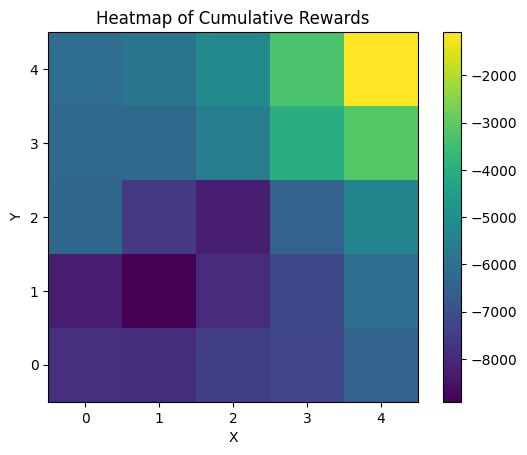

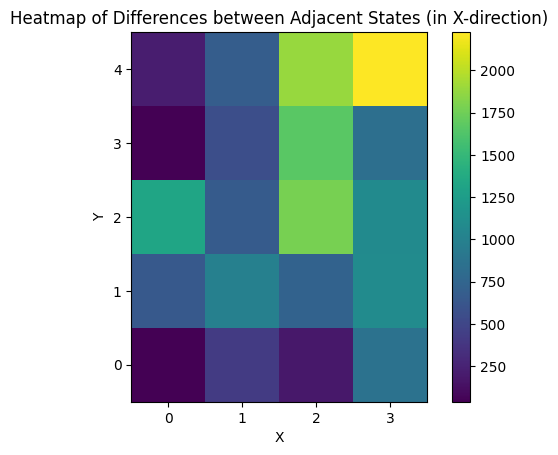

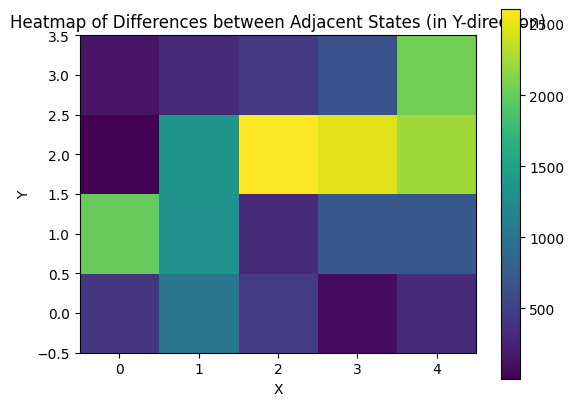

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid to store cumulative rewards for each state
height = 5
width = 5
cumulative_rewards_grid = np.zeros((height, width))

# Loop through all trajectories and accumulate cumulative rewards for each state
for trajectory in behavior_policies:
    for _, _, reward, next_state, cumulative_reward in trajectory:
        x, y = next_state
        cumulative_rewards_grid[y, x] += cumulative_reward

# # Create the heatmap
plt.imshow(cumulative_rewards_grid, cmap='viridis', origin='lower')

# Add colorbar for better visualization
plt.colorbar()

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of Cumulative Rewards')

# Show the plot
plt.show()

# Calculate the differences between adjacent states
diff_x = np.abs(np.diff(cumulative_rewards_grid, axis=1))
diff_y = np.abs(np.diff(cumulative_rewards_grid, axis=0))

# Create the heatmap for differences in x-direction
plt.imshow(diff_x, cmap='viridis', origin='lower')

# Add colorbar for better visualization
plt.colorbar()

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of Differences between Adjacent States (in X-direction)')

# Show the plot
plt.show()

# Create the heatmap for differences in y-direction
plt.imshow(diff_y, cmap='viridis', origin='lower')

# Add colorbar for better visualization
plt.colorbar()

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of Differences between Adjacent States (in Y-direction)')

# Show the plot
plt.show()



In [ ]:
diff_x

array([[  39.5,  422.5,  183. ,  866. ],
       [ 651. ,  993.5,  726. , 1096. ],
       [1324.5,  664.5, 1781.5, 1085. ],
       [  42.5,  569. , 1663. ,  835. ],
       [ 215.5,  684.5, 1889. , 2226. ]])

In [ ]:
diff_y

array([[ 415. , 1026.5,  455.5,   87.5,  317.5],
       [2006. , 1332.5,  325.5,  730. ,  719. ],
       [   5. , 1372. , 2605.5, 2487. , 2237. ],
       [ 147. ,  320. ,  435.5,  661.5, 2052.5]])

In [ ]:
cumulative_rewards_grid

array([[-7840. , -7879.5, -7457. , -7274. , -6408. ],
       [-8255. , -8906. , -7912.5, -7186.5, -6090.5],
       [-6249. , -7573.5, -8238. , -6456.5, -5371.5],
       [-6244. , -6201.5, -5632.5, -3969.5, -3134.5],
       [-6097. , -5881.5, -5197. , -3308. , -1082. ]])

In [57]:
# Gridworld for evaluation policy
height = 5
width = 5
start = (0, 0)
end = (4, 4)
bad_regions = [(1, 1), (2, 2)]
good_regions = [(3, 3)]

env = GridWorld(height, width, start, end, bad_regions, good_regions)

# Create a list to store evaluation policies as trajectories
evaluation_policies = []

# Number of episodes
num_episodes = 200

# Run multiple episodes
for episode in range(num_episodes):
    # Create a new Agent for each episode to generate a different behavior policy
    agent = Agent(epsilon=0.0)

    # Run an episode
    env.reset()
    done = False
    trajectory = []  # Store the trajectory for the current episode
    cumulative_reward = 0.0  # Initialize cumulative reward
    while not done:
        state = env.agent_position  # Get the current state
        action = agent.select_action(evaluation_policy)
        next_state, reward, done = env.step(action)

        # Compute cumulative reward
        cumulative_reward += reward

        # Store the (state, action, reward, next_state) tuple in the trajectory
        trajectory.append((state, action, reward, next_state, cumulative_reward))

        # Print the episode information
        print("Episode:", episode + 1)
        print("State:", state)
        print("Action:", action)
        print("Reward:", reward)
        print("Next State:", next_state)
        print("Cumulative Reward:", cumulative_reward)
        print("Done:", done)
        print("-----")

    # Append the trajectory to the behavior policies list
    evaluation_policies.append(trajectory)


Streaming output truncated to the last 5000 lines.
Episode: 163
State: (1, 0)
Action: up
Reward: -1
Next State: (1, 1)
Cumulative Reward: -1.0
Done: False
-----
Episode: 163
State: (1, 1)
Action: right
Reward: 0
Next State: (2, 1)
Cumulative Reward: -1.0
Done: False
-----
Episode: 163
State: (2, 1)
Action: right
Reward: 0
Next State: (3, 1)
Cumulative Reward: -1.0
Done: False
-----
Episode: 163
State: (3, 1)
Action: right
Reward: 0
Next State: (4, 1)
Cumulative Reward: -1.0
Done: False
-----
Episode: 163
State: (4, 1)
Action: up
Reward: 0
Next State: (4, 2)
Cumulative Reward: -1.0
Done: False
-----
Episode: 163
State: (4, 2)
Action: right
Reward: 0
Next State: (4, 2)
Cumulative Reward: -1.0
Done: False
-----
Episode: 163
State: (4, 2)
Action: up
Reward: 0
Next State: (4, 3)
Cumulative Reward: -1.0
Done: False
-----
Episode: 163
State: (4, 3)
Action: right
Reward: 0
Next State: (4, 3)
Cumulative Reward: -1.0
Done: False
-----
Episode: 163
State: (4, 3)
Action: up
Reward: 3
Next State: (

In [71]:
# Initialize a variable to store the sum of all cumulative rewards
total_cumulative_reward = 0.0

# Iterate through the evaluation_policies list to sum up the rewards
for episode_trajectory in evaluation_policies:
    # Get the last tuple (state, action, reward, next_state, cumulative_reward)
    # from the trajectory to get the cumulative reward of the episode
    cumulative_reward_episode = episode_trajectory[-1][-1]

    # Add the episode's cumulative reward to the total cumulative reward
    total_cumulative_reward += cumulative_reward_episode

# Print the total cumulative reward
print("Mean Cumulative Reward of 200 evaluation policies:", total_cumulative_reward/len(evaluation_policies))


Mean Cumulative Reward of 200 evaluation policies: 2.15


In [37]:
evaluation_policies[178][-1][-1]

1.5

In [36]:
cumulative_reward_episode

3.0

# OPE Calculations

In [13]:
# all_weights = calculate_importance_weights(eval_policy, behav_policy,behavior_policies)

In [ ]:
# # Step 1: Calculate Importance Weights
# eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
# behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}

# # Calculate the importance weights for each trajectory in behavior_policies
# all_weights = calculate_importance_weights(eval_policy, behav_policy, behavior_policies)

# # Step 2: Bootstrap Resampling
# num_bootstrap_samples = 100  # Number of bootstrap samples to generate
# bootstrap_samples = [np.random.choice(behavior_policies, size=len(behavior_policies), replace=True)
#                      for _ in range(num_bootstrap_samples)]

# # Step 3: Per-Step Importance Sampling (IS) Estimates
# all_timesteps_list = []
# V_all = []
# for bootstrap_sample in bootstrap_samples:
#     # Calculate importance weights for this bootstrap sample
#     bootstrap_weights = calculate_importance_weights(eval_policy, behav_policy, bootstrap_sample)

#     # Calculate per-step IS estimates for this bootstrap sample
#     all_timesteps, V = per_step_IS(bootstrap_weights, bootstrap_sample)

#     all_timesteps_list.append(all_timesteps)
#     V_all.append(V)

# # Step 4: Variance Estimation
# # Calculate the variance of the per-step IS estimates for each time step
# variances = np.var(V_all, axis=0)

# # Calculate the mean of the per-step IS estimates for each time step (optional, for visualization)
# mean_IS_estimates = np.mean(V_all, axis=0)

# # Print or visualize the variances and mean IS estimates
# print("Per-step IS estimates (mean):", mean_IS_estimates)
# print("Per-step IS variances:", variances)


<ipython-input-10-6ba03e290771>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bootstrap_samples = [np.random.choice(behavior_policies, size=len(behavior_policies), replace=True)


Per-step IS estimates (mean): -0.1245277129215959
Per-step IS variances: 0.0004130924942039972


# Training Reward Models

## State -> Reward

Training model to predict rewards based on state only

In [ ]:
import tensorflow as tf
import numpy as np

# Step 1: Prepare the data
# behavior_policies = [...]  # Replace [...] with your actual behavior_policies list

# Initialize lists to store all 'next_state' and 'reward' values
all_next_states = []
all_rewards = []

# Extract the 'next_state' and 'reward' from the 'behavior_policies' list
for trajectory in behavior_policies:
    # For each trajectory, extract all 'next_state' and 'reward' values
    next_states = [state_action_reward[3] for state_action_reward in trajectory]
    rewards = [state_action_reward[2] for state_action_reward in trajectory]

    # Append the values to the corresponding lists
    all_next_states.extend(next_states)
    all_rewards.extend(rewards)

# Convert 'next_states' and 'rewards' into appropriate formats for training
all_next_states = np.array(all_next_states, dtype=np.float32)
all_rewards = np.array(all_rewards, dtype=np.float32)

# Now, 'all_next_states' contains all the 'next_state' values, and 'all_rewards' contains all the corresponding rewards.


In [ ]:
len(all_rewards)

21499

In [ ]:
# Step 2: Design the neural network
class RewardPredictorStates(tf.keras.Model):
    def __init__(self, input_shape):
        super(RewardPredictorStates, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x

# Define hyperparameters for the neural network
input_shape = all_next_states.shape[1:]  # Shape of the input state (excluding batch size)
learning_rate = 0.005
num_epochs = 1000
batch_size = 32

# Create the neural network
reward_predictor_states = RewardPredictorStates(input_shape)

# Compile the model
reward_predictor_states.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                         loss='mean_squared_error')

# Step 3: Train the neural network with early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
]

reward_predictor_states.fit(
    all_next_states, all_rewards,
    batch_size=batch_size, epochs=num_epochs,
    callbacks=callbacks, validation_split=0.2, verbose=1
)

Epoch 1/1000


KeyboardInterrupt: ignored

In [ ]:
current_state = behavior_policies[0][5][0]
current_state = np.array(current_state, dtype=np.float32)
predicted_reward_current = reward_predictor_states.predict(np.expand_dims(current_state, axis=0))
print("Predicted Reward Current State:", predicted_reward_current[0, 0])

new_state = behavior_policies[0][5][3]  # Replace ... with the new state for which you want to predict the reward
new_state = np.array(new_state, dtype=np.float32)
predicted_reward_next = reward_predictor_states.predict(np.expand_dims(new_state, axis=0))
print("Predicted Reward Next State:", predicted_reward_next[0, 0])

1/1 [==============================] - 0s 20ms/step
Predicted Reward Current State: -0.03829813
1/1 [==============================] - 0s 20ms/step
Predicted Reward Next State: -0.006269932


## State -> Cumulative Reward

Reward model based on State -> Cumulative Rewards

In [ ]:
import tensorflow as tf
import numpy as np

# Step 1: Prepare the data
# behavior_policies = [...]  # Replace [...] with your actual behavior_policies list

# Initialize lists to store all 'next_state' and 'reward' values
all_next_states = []
all_cum_rewards = []

# Extract the 'next_state' and 'reward' from the 'behavior_policies' list
for trajectory in behavior_policies:
    # For each trajectory, extract all 'next_state' and 'reward' values
    next_states = [state_action_reward[3] for state_action_reward in trajectory]
    cum_rewards = [state_action_reward[4] for state_action_reward in trajectory]

    # Append the values to the corresponding lists
    all_next_states.extend(next_states)
    all_cum_rewards.extend(cum_rewards)

# Convert 'next_states' and 'rewards' into appropriate formats for training
all_next_states = np.array(all_next_states, dtype=np.float32)
all_cum_rewards = np.array(all_cum_rewards, dtype=np.float32)

# Now, 'all_next_states' contains all the 'next_state' values, and 'all_rewards' contains all the corresponding rewards.


In [ ]:
len(all_cum_rewards)

21499

In [ ]:
# Step 2: Design the neural network
# import tensorflow as tf

class RewardPredictorCumulative(tf.keras.Model):
    def __init__(self, input_shape):
        super(RewardPredictorCumulative, self).__init__()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.dense2 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01))
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.dense3 = tf.keras.layers.Dense(1, kernel_initializer='he_normal')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.batch_norm1(x)
        x = self.dense2(x)
        x = self.batch_norm2(x)
        x = self.dense3(x)
        return x


# Define hyperparameters for the neural network
input_shape = all_next_states.shape[1:]  # Shape of the input state (excluding batch size)
learning_rate = 0.0001
num_epochs = 1000
batch_size = 32

# Create the neural network
reward_predictor_cumulative = RewardPredictorCumulative(input_shape)

# Compile the model
reward_predictor_cumulative.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                         loss='mean_squared_error')

# Step 3: Train the neural network with early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
]

reward_predictor_cumulative.fit(
    all_next_states, all_cum_rewards,
    batch_size=batch_size, epochs=num_epochs,
    callbacks=callbacks, validation_split=0.2, verbose=1
)

Epoch 1/1000
2691/2691 [==============================] - 14s 4ms/step - loss: 14287.8623 - val_loss: 9193.1582
Epoch 2/1000
2691/2691 [==============================] - 12s 4ms/step - loss: 12563.5850 - val_loss: 7138.1450
Epoch 3/1000
2691/2691 [==============================] - 12s 4ms/step - loss: 10212.1973 - val_loss: 5365.0083
Epoch 4/1000
2691/2691 [==============================] - 12s 4ms/step - loss: 8540.7607 - val_loss: 4638.1211
Epoch 5/1000
2691/2691 [==============================] - 12s 4ms/step - loss: 7985.4175 - val_loss: 4635.2275
Epoch 6/1000
2691/2691 [==============================] - 12s 4ms/step - loss: 7930.9414 - val_loss: 4674.1807
Epoch 7/1000
2691/2691 [==============================] - 12s 4ms/step - loss: 7929.3970 - val_loss: 4667.2554
Epoch 8/1000
2691/2691 [==============================] - 12s 4ms/step - loss: 7929.0581 - val_loss: 4669.0732
Epoch 9/1000
2691/2691 [==============================] - 12s 4ms/step - loss: 7927.9824 - val_loss: 4675.181

## State -> Rewards over past 3 timesteps

Cumulative rewards over 3 timesteps

In [ ]:
# Discounted sum
# Create a new list to store trajectories with the new data
augmented_behavior_policies = []

# Set the discount factor (gamma)
discount_factor = 0.9  # You can adjust this value as needed (usually between 0 and 1)

# Iterate through each trajectory in behavior_policies
for trajectory in behavior_policies:
    num_timesteps = len(trajectory)
    new_trajectory = []

    # Iterate through each timestep in the trajectory
    for t in range(num_timesteps):
        # Calculate the discounted sum of the past 3 rewards for the past 3 timesteps
        discounted_sum = 0.0
        for i in range(1, min(4, t + 1)):
            discounted_sum += (discount_factor ** (i - 1)) * trajectory[t - i][2]

        # Update the trajectory to include only the discounted sum of the past 3 rewards
        state, action, reward, next_state, cumulative_reward, good_prox, bad_prox = trajectory[t]
        new_trajectory.append((state, discounted_sum, action, reward, next_state, cumulative_reward))

    # Append the modified trajectory to the augmented_behavior_policies list
    augmented_behavior_policies.append(new_trajectory)


In [ ]:
# Discounted sum
# Create a new list to store trajectories with the new data
augmented_evaluation_policies = []

# Set the discount factor (gamma)
discount_factor = 0.9  # You can adjust this value as needed (usually between 0 and 1)

# Iterate through each trajectory in evaluation_policies
for trajectory in evaluation_policies:
    num_timesteps = len(trajectory)
    new_trajectory = []

    # Iterate through each timestep in the trajectory
    for t in range(num_timesteps):
        # Calculate the discounted sum of the past 3 rewards for the past 3 timesteps
        discounted_sum = 0.0
        for i in range(1, min(4, t + 1)):
            discounted_sum += (discount_factor ** (i - 1)) * trajectory[t - i][2]

        # Update the trajectory to include only the discounted sum of the past 3 rewards
        state, action, reward, next_state, cumulative_reward, good_prox. bad_prox = trajectory[t]
        new_trajectory.append((state, discounted_sum, action, reward, next_state, cumulative_reward))

    # Append the modified trajectory to the augmented_evaluation_policies list
    augmented_evaluation_policies.append(new_trajectory)


NameError: ignored

In [ ]:
import tensorflow as tf
import numpy as np

# Step 1: Prepare the data
def preprocess_nstep_data(policy_data):
  # Initialize lists to store all 'next_state' and 'reward' values
  all_next_states = []
  all_past3_rewards = []

  # Extract the 'next_state' and 'reward' from the 'behavior_policies' list
  for trajectory in policy_data:
      # For each trajectory, extract all 'next_state' and 'reward' values
      next_states = [state_action_reward[4] for state_action_reward in trajectory]
      rewards = [state_action_reward[3] for state_action_reward in trajectory]

      # Append the values to the corresponding lists
      all_next_states.extend(next_states)
      all_past3_rewards.extend(rewards)

  # Convert 'next_states' and 'rewards' into appropriate formats for training
  all_next_states = np.array(all_next_states, dtype=np.float32)
  all_past3_rewards = np.array(all_past3_rewards, dtype=np.float32)
  return all_next_states, all_past3_rewards

In [ ]:
# Step 2: Design the neural network
class RewardPredictor3States(tf.keras.Model):
    def __init__(self, input_shape):
        super(RewardPredictor3States, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return x


In [ ]:
# Behavior policies training
all_next_states_behav, all_past3_rewards_behav = preprocess_nstep_data(augmented_behavior_policies)

# Define hyperparameters for the neural network
input_shape = all_next_states_behav.shape[1:]  # Shape of the input state (excluding batch size)
learning_rate = 0.005
num_epochs = 1000
batch_size = 32

# Create the neural network
reward_predictor_3states = RewardPredictor3States(input_shape)

# Compile the model
reward_predictor_3states.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                         loss='mean_squared_error')

# Step 3: Train the neural network with early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
]

reward_predictor_3states.fit(
    all_next_states_behav, all_past3_rewards_behav,
    batch_size=batch_size, epochs=num_epochs,
    callbacks=callbacks, validation_split=0.2, verbose=1
)

Epoch 1/1000
541/541 [==============================] - 2s 2ms/step - loss: 0.1163 - val_loss: 0.0807
Epoch 2/1000
541/541 [==============================] - 1s 2ms/step - loss: 0.0498 - val_loss: 0.0302
Epoch 3/1000
541/541 [==============================] - 1s 2ms/step - loss: 0.0184 - val_loss: 0.0124
Epoch 4/1000
541/541 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0050
Epoch 5/1000
541/541 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 6/1000
541/541 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/1000
541/541 [==============================] - 1s 2ms/step - loss: 8.8721e-04 - val_loss: 6.9921e-04
Epoch 8/1000
541/541 [==============================] - 1s 2ms/step - loss: 5.3470e-04 - val_loss: 2.7174e-04
Epoch 9/1000
541/541 [==============================] - 1s 2ms/step - loss: 3.5016e-04 - val_loss: 4.5576e-04
Epoch 10/1000
541/541 [==============================] - 1

In [ ]:
current_state = [2,3]
current_state = np.array(current_state, dtype=np.float32)
predicted_reward_current = reward_predictor_3states.predict(np.expand_dims(current_state, axis=0))
print("Predicted Reward Current State:", predicted_reward_current[0, 0])

1/1 [==============================] - 0s 23ms/step
Predicted Reward Current State: 0.0006133178


In [ ]:
# Evaluation policies training
all_next_states_eval, all_past3_rewards_eval = preprocess_nstep_data(augmented_evaluation_policies)

# Define hyperparameters for the neural network
input_shape = all_next_states_eval.shape[1:]  # Shape of the input state (excluding batch size)
learning_rate = 0.005
num_epochs = 1000
batch_size = 32

# Create the neural network
reward_predictor_3states_eval = RewardPredictor3States(input_shape)

# Compile the model
reward_predictor_3states_eval.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                         loss='mean_squared_error')

# Step 3: Train the neural network with early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
]

reward_predictor_3states_eval.fit(
    all_next_states_eval, all_past3_rewards_eval,
    batch_size=batch_size, epochs=num_epochs,
    callbacks=callbacks, validation_split=0.2, verbose=1
)

Epoch 1/1000
83/83 [==============================] - 1s 4ms/step - loss: 0.4849 - val_loss: 0.4438
Epoch 2/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.4098 - val_loss: 0.4183
Epoch 3/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3815 - val_loss: 0.4099
Epoch 4/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.3551 - val_loss: 0.3524
Epoch 5/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.3321 - val_loss: 0.3293
Epoch 6/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.3087 - val_loss: 0.3227
Epoch 7/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.2799 - val_loss: 0.2717
Epoch 8/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.2471 - val_loss: 0.2828
Epoch 9/1000
83/83 [==============================] - 0s 3ms/step - loss: 0.2288 - val_loss: 0.2699
Epoch 10/1000
83/83 [==============================] - 0s 2ms/step - loss: 0.2065 - val_loss: 0.1874

In [ ]:
current_state = [4,3]
current_state = np.array(current_state, dtype=np.float32)
predicted_reward_current = reward_predictor_3states_eval.predict(np.expand_dims(current_state, axis=0))
print("Predicted Reward Current State:", predicted_reward_current[0, 0])

1/1 [==============================] - 0s 33ms/step
Predicted Reward Current State: 0.00042444468


State, action, Next State -> Reward

In [ ]:

# import tensorflow as tf
# import numpy as np

# # Step 1: Prepare the data
# behavior_policies = [...]  # Replace [...] with your actual behavior_policies list

# # Initialize lists to store all 'current_state', 'action', 'next_state', and 'reward' values
# all_current_states = []
# all_actions = []
# all_next_states = []
# all_rewards = []

# # Extract the 'current_state', 'action', 'next_state', and 'reward' from the 'behavior_policies' list
# for trajectory in behavior_policies:
#     for state, action, reward, next_state in trajectory:
#         all_current_states.append(state)
#         all_actions.append(action)
#         all_next_states.append(next_state)
#         all_rewards.append(reward)

# # Convert 'current_states', 'actions', 'next_states', and 'rewards' into appropriate formats for training
# all_current_states = np.array(all_current_states, dtype=np.float32)
# all_actions = np.array(all_actions, dtype=np.float32)
# all_next_states = np.array(all_next_states, dtype=np.float32)
# all_rewards = np.array(all_rewards, dtype=np.float32)

## State + proximity to good/bad regions -> Cumulative Reward

# OPE Calculations

In [74]:
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
def calculate_importance_weights(eval_policy, behav_policy, behavior_policies):
  all_weights = []
  for trajectory in behavior_policies:
    cum_ratio = 1
    cumul_weights = []
    for step in trajectory:
        ratio = eval_policy[step[1]]/behav_policy[step[1]]
        # print("Ratio:",ratio)
        cum_ratio *= ratio
        cumul_weights.append(cum_ratio)
        # print("Cumul:",cum_ratio)
    all_weights.append(cumul_weights)

  return all_weights

In [100]:
def per_step_IS(all_weights, behavior_policies):
  all_timesteps = []
  gamma = 0.9
  for j in range(len(all_weights)):
    Timestep_values = []
    for i in range(len(all_weights[j])-1):
      timestep = gamma**(i)*all_weights[j][i]*behavior_policies[j][i][2]
      # print("Timestep: ",timestep)
      Timestep_values.append(timestep)

    all_timesteps.append(Timestep_values)
  V = sum([sum(sublist) for sublist in all_timesteps])/len(all_weights)
  return V

## SCOPE

In [76]:
# beta =  [ 0.24443418,  0.30068975, -0.40465262]
def SCOPE(all_weights, behavior_policies,beta):
  all_timesteps = []
  gamma = 0.9
  for j in range(len(all_weights)):
    Timestep_values = []
    for i in range(len(all_weights[j])-1):
      features = behavior_policies[j][i][5] + behavior_policies[j][i][6]
      features_next = behavior_policies[j][i+1][5] + behavior_policies[j][i+1][6]
      timestep = gamma**(i)*all_weights[j][i]*(behavior_policies[j][i][2] + gamma*phi(features_next,beta) - phi(features,beta))
      Timestep_values.append(timestep)

    all_timesteps.append(Timestep_values)
  V = sum([sum(sublist) for sublist in all_timesteps])/len(all_weights)
  return V

In [ ]:
# Variance calculations


# Variance Terms Preparation and Calculation

In [77]:
import numpy as np

def phi(features, beta):
  features = np.array(features)
  beta = np.array(beta)
  phi_s = np.dot(beta,features)
  return phi_s


In [78]:
import random
# gamma = 0.9
# beta = [random.random() for _ in range(3)]
def variance_terms(policy_set,gamma, beta):
  all_weights = calculate_importance_weights(eval_policy, behav_policy, policy_set)
  y_w_r_all = 0
  r_all = 0
  f_a = 0
  for j in range(len(policy_set)):
    y_w_r = 0
    r = 0
    for i in range(len(policy_set[j])):
      features = policy_set[j][i][5]+policy_set[j][i][6]
      y_w_r += gamma**(i)*all_weights[j][i]*policy_set[j][i][2]
      if i>0 & i<len(policy_set):
        r += phi(features, beta)*(all_weights[j][i-1]-all_weights[j][i])
    y_w_r_all += y_w_r
    f_a +=  gamma**(len(policy_set[j]))*all_weights[j][-1]*phi(features,beta) - phi(features, beta) # fix the features part
    r_all += r

  IS = y_w_r_all/len(policy_set)
  R = r_all/len(policy_set)
  F = f_a/len(policy_set)
  return IS, R, F


In [79]:
def calc_variance(behavior_policies, gamma, beta):
  # Set the seed value (you can use any integer value)
  seed_value = 42
  np.random.seed(seed_value)
  num_bootstrap_samples = 100  # Number of bootstrap samples to generate
  bootstrap_samples = [np.random.choice(behavior_policies, size=len(behavior_policies), replace=True)
                     for _ in range(num_bootstrap_samples)]
  IS_all = []
  R_all = []
  F_all = []

  for pol in bootstrap_samples:
    IS, R, F = variance_terms(pol,0.9,beta)
    IS_all.append(IS)
    R_all.append(R)
    F_all.append(F)
  IS_sq = np.mean([num**2 for num in IS_all])
  IS_R_F = 2*np.mean([IS_all[i]*(R_all[i]+F_all[i]) for i in range(len(IS_all))])
  R_sq = np.mean([num**2 for num in R_all])
  IS_sq_all = (np.mean(IS_all))**2
  IS_r_t_f = 2*np.mean(IS_all)*np.mean([R_all[i]+F_all[i] for i in range(len(R_all))])
  R_sq_all = (np.mean(R_all))**2

  variance_scope = IS_sq + IS_R_F + R_sq - IS_sq_all - IS_r_t_f - R_sq_all
  variance_is = IS_sq - IS_sq_all
  return IS_all, R_all, F_all, variance_scope, variance_is
  # return IS_sq, IS_R_F, R_sq, IS_sq_all, IS_r_t_f, R_sq_all

In [114]:
IS_all, R_all, F_all, variance_scope, variance_is = calc_variance(behavior_policies,0.9,[-0.1,.1,.1])
print("Var SCOPE: ",variance_scope)
print("Var IS: ",variance_is)
print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)

<ipython-input-79-22418df8b347>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bootstrap_samples = [np.random.choice(behavior_policies, size=len(behavior_policies), replace=True)


Var SCOPE:  0.025360229675781828
Var IS:  0.029827248473569323
Percent change in variance:  14.976301960088051


In [117]:
print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)

Percent change in variance:  -14.976301960088051


In [80]:
IS_all, R_all, F_all, variance_scope, variance_is = calc_variance(behavior_policies,0.9,[ 0.2610704,   0.30396575, -0.43850237])
print("Var SCOPE: ",variance_scope)
print("Var IS: ",variance_is)
print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)

<ipython-input-79-22418df8b347>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bootstrap_samples = [np.random.choice(behavior_policies, size=len(behavior_policies), replace=True)


In [81]:
print("Var SCOPE: ",variance_scope)
print("Var IS: ",variance_is)
print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)

Var SCOPE:  0.015075898161348182
Var IS:  0.029827248473569323
improvement:  49.45595409275745


# Optimization

In [43]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function to minimize variance_scope
def objective_function(beta):
    IS_all, R_all, F_all, variance_scope, variance_is = calc_variance(behavior_policies, 0.9, beta)
    return variance_scope

# Set the initial values of beta
initial_beta = np.array([ 0.2610704,   0.30396575, -0.43850237])

# Lists to store beta and variance_scope values at each iteration
all_betas = []
all_variance_scopes = []

# Callback function to record beta and variance_scope values at each iteration
def callback_function(beta):
    all_betas.append(beta.copy())
    variance_scope = objective_function(beta)
    all_variance_scopes.append(variance_scope)
    print("Iteration:", len(all_betas))
    print("Beta:", beta)
    print("Variance Scope:", variance_scope)
    print("----------")

# Run the optimization with the callback
result = minimize(objective_function, initial_beta, method='L-BFGS-B', callback=callback_function)

# Extract the optimal beta values
optimal_beta = result.x

# Print the result
print("Optimal Beta Values:", optimal_beta)


<ipython-input-40-22418df8b347>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bootstrap_samples = [np.random.choice(behavior_policies, size=len(behavior_policies), replace=True)


Iteration: 1
Beta: [ 0.26288465  0.31249517 -0.43308314]
Variance Scope: 0.03890192180671534
----------
Iteration: 2
Beta: [ 0.25760065  0.3139119  -0.4324235 ]
Variance Scope: 0.038879962562817755
----------
Iteration: 3
Beta: [ 0.25099805  0.31446644 -0.42970297]
Variance Scope: 0.03886889032715903
----------
Iteration: 4
Beta: [ 0.24972093  0.31338761 -0.42732695]
Variance Scope: 0.038866587917230196
----------
Iteration: 5
Beta: [ 0.24414824  0.30446678 -0.41038807]
Variance Scope: 0.0388566913198793
----------
Iteration: 6
Beta: [ 0.24427272  0.30086003 -0.40483056]
Variance Scope: 0.038855107068841224
----------
Iteration: 7
Beta: [ 0.24443418  0.30068975 -0.40465262]
Variance Scope: 0.03885509432490412
----------
Optimal Beta Values: [ 0.24443418  0.30068975 -0.40465262]


In [10]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function to minimize variance_scope
def objective_function(beta):
    IS_all, R_all, F_all, variance_scope, variance_is = calc_variance(behavior_policies, 0.9, beta)
    return variance_scope

# Set the initial values of beta
initial_beta = np.array([1, -0.1, -0.1])

# Lists to store beta and variance_scope values at each iteration
all_betas = []
all_variance_scopes = []

# Callback function to record beta and variance_scope values at each iteration
def callback_function(beta):
    all_betas.append(beta.copy())
    variance_scope = objective_function(beta)
    all_variance_scopes.append(variance_scope)
    print("Iteration:", len(all_betas))
    print("Beta:", beta)
    print("Variance Scope:", variance_scope)
    print("----------")

# Run the optimization with the callback
result = minimize(objective_function, initial_beta, method='L-BFGS-B', callback=callback_function)

# Extract the optimal beta values
optimal_beta = result.x

# Print the result
print("Optimal Beta Values:", optimal_beta)


<ipython-input-7-b436dd9eb8ff>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bootstrap_samples = [np.random.choice(behavior_policies, size=len(behavior_policies), replace=True)


Iteration: 1
Beta: [ 0.74558738 -0.0727051  -0.13429517]
Variance Scope: 0.17205980293372852
----------
Iteration: 2
Beta: [ 0.51422013  0.01444041 -0.13118779]
Variance Scope: 0.10132221718839504
----------
Iteration: 3
Beta: [ 0.21974179  0.12674824 -0.12945906]
Variance Scope: 0.06890789685172624
----------
Iteration: 4
Beta: [ 0.22100604  0.15532669 -0.17596816]
Variance Scope: 0.06790719356206737
----------
Iteration: 5
Beta: [ 0.2578635   0.30333719 -0.43552043]
Variance Scope: 0.06528770052678368
----------
Iteration: 6
Beta: [ 0.26104719  0.30397559 -0.43850381]
Variance Scope: 0.0652844236998165
----------
Iteration: 7
Beta: [ 0.2610704   0.30396575 -0.43850237]
Variance Scope: 0.06528442349549637
----------
Optimal Beta Values: [ 0.2610704   0.30396575 -0.43850237]


In [100]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function to minimize variance_scope
def objective_function(beta):
    IS_all, R_all, F_all, variance_scope, variance_is = calc_variance(behavior_policies, 0.9, beta)
    return variance_scope

# Set the initial values of beta
initial_beta = np.array([1, -0.1, -0.1])

# Lists to store beta and variance_scope values at each iteration
all_betas = []
all_variance_scopes = []

# Callback function to record beta and variance_scope values at each iteration
def callback_function(beta):
    all_betas.append(beta.copy())
    variance_scope = objective_function(beta)
    all_variance_scopes.append(variance_scope)
    print("Iteration:", len(all_betas))
    print("Beta:", beta)
    print("Variance Scope:", variance_scope)
    print("----------")

# Run the optimization with the callback
result = minimize(objective_function, initial_beta, method='L-BFGS-B', callback=callback_function)

# Extract the optimal beta values
optimal_beta = result.x

# Print the result
print("Optimal Beta Values:", optimal_beta)


<ipython-input-80-b436dd9eb8ff>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bootstrap_samples = [np.random.choice(behavior_policies, size=len(behavior_policies), replace=True)


Iteration: 1
Beta: [ 0.95461424 -0.18038518 -0.14714184]
Variance Scope: 0.11818026023735667
----------
Iteration: 2
Beta: [ 0.9016154  -0.156789   -0.15068515]
Variance Scope: 0.10796090614265882
----------
Iteration: 3
Beta: [ 0.46725172  0.10210465 -0.29978589]
Variance Scope: 0.06275082447768895
----------
Iteration: 4
Beta: [ 0.44485279  0.171732   -0.410621  ]
Variance Scope: 0.05877067174584359
----------
Iteration: 5
Beta: [ 0.46031673  0.3296736  -0.71168708]
Variance Scope: 0.05390185593164576
----------
Iteration: 6
Beta: [ 0.46135818  0.32966832 -0.7124576 ]
Variance Scope: 0.05390157377166176
----------
Iteration: 7
Beta: [ 0.46138779  0.32965123 -0.71244844]
Variance Scope: 0.05390157358436144
----------
Optimal Beta Values: [ 0.46138779  0.32965123 -0.71244844]


# Value estimates of IS and SCOPE estimators

In [82]:
all_weights = calculate_importance_weights(eval_policy, behav_policy, behavior_policies)

In [110]:
beta = [-1,1,1]
# beta =  [ 0.24443418,  0.30068975, -0.40465262]
V_SCOPE = SCOPE(all_weights, behavior_policies,beta)
print("SCOPE values estimate: %f and variance: %f" % (V_SCOPE,variance_scope))

SCOPE values estimate: 1.024355 and variance: 0.015076


In [103]:
V = per_step_IS(all_weights, behavior_policies)
print("IS values estimate: %f and variance: %f" % (V,variance_is))

IS values estimate: -0.735629 and variance: 0.029827
